In [8]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import pandera as pa
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from schemas.log_returns import schema_log_returns
from utils.loaders import load_validated_parquet

In [3]:
DATA_DIR = Path('./assets/')
RAW_DIR = DATA_DIR / 'raw'
GOOG_FILE = RAW_DIR / 'goog_return_2021.parquet'
SP_FILE = RAW_DIR / 'sp500_returns_2021.parquet'

In [11]:
df_goog = load_validated_parquet(GOOG_FILE, schema=schema_log_returns)
df_sp500 = load_validated_parquet(SP_FILE, schema=schema_log_returns)

In [18]:
df_returns = (
    df_goog.rename(columns={"log_return": "GOOG"})
    .merge(
        df_sp500.rename(columns={"log_return": "SP500"}),
        left_index=True,
        right_index=True,
        how="inner"
    )
)
df_returns.head()

,GOOG,SP500
Date,,
2021-01-05,0.007310,0.007058
2021-01-06,-0.003239,0.005694
2021-01-07,0.029504,0.014738
2021-01-08,0.011106,0.005477
2021-01-11,-0.022659,-0.006576


In [22]:
X = sm.add_constant(df_returns['SP500'])
Y = df_returns['GOOG']

In [23]:
X

,const,SP500
Date,,
2021-01-05,1.0,0.007058
2021-01-06,1.0,0.005694
2021-01-07,1.0,0.014738
2021-01-08,1.0,0.005477
2021-01-11,1.0,-0.006576
...,...,...
2021-12-27,1.0,0.013744
2021-12-28,1.0,-0.001011
2021-12-29,1.0,0.001401


In [26]:
model = sm.OLS(Y, X).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GOOG   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     231.5
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           2.06e-37
Time:                        12:34:58   Log-Likelihood:                 783.32
No. Observations:                 251   AIC:                            -1563.
Df Residuals:                     249   BIC:                            -1556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.154      0.249      -0.001       0.002
SP500          1.2562      0.083     15.216      0.000       1.094       1.419
==============================================================================
Omnibus:                      105.087   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              999.479
Skew:                           1.379   Prob(JB):                    9.25e-218
Kurtosis:                      12.379   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
alpha = model.params['const']
beta = model.params['SP500']

In [30]:
alpha

np.float64(0.0007869311314574242)

In [31]:
beta

np.float64(1.2562396129283027)

In [32]:
x_min, x_max = df_returns["SP500"].min(), df_returns["SP500"].max()
x_grid = np.linspace(x_min, x_max, 200)
X_grid = sm.add_constant(pd.Series(x_grid, name="SP500"))
y_hat  = model.predict(X_grid)

In [33]:
sns.set_theme(context="talk", style="whitegrid")

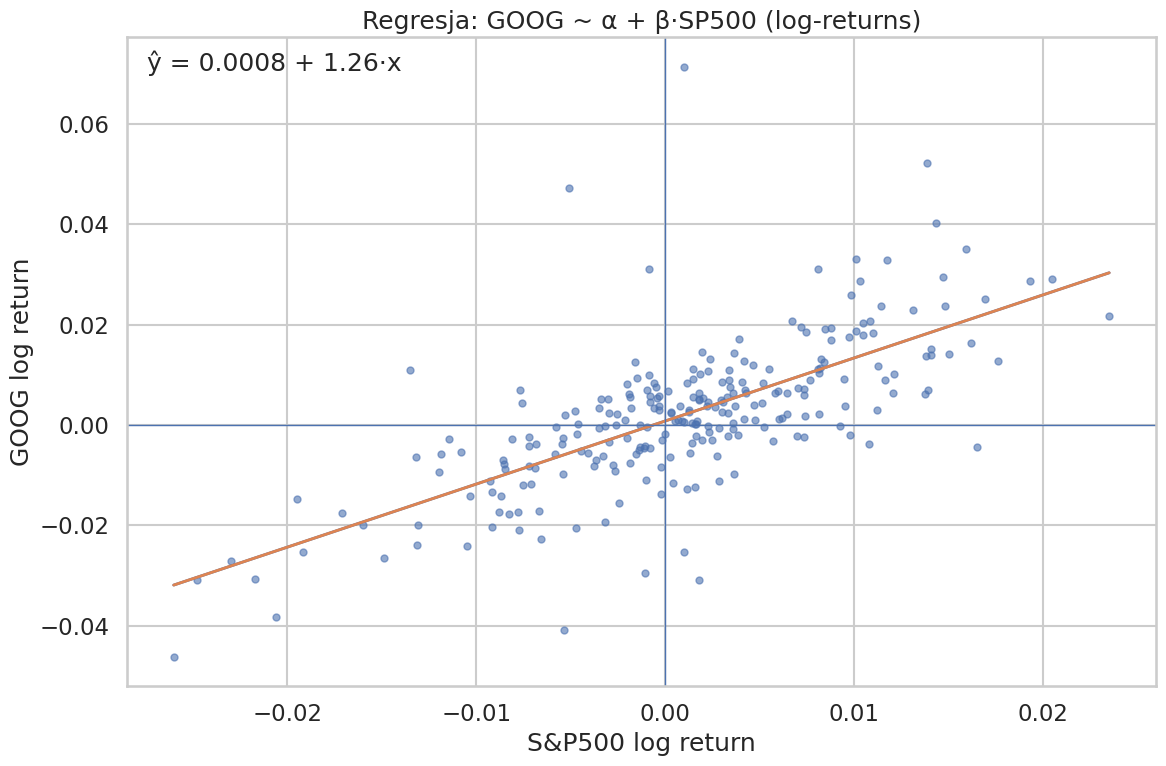

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.regplot(
    data=df_returns,
    x="SP500",
    y="GOOG",
    scatter_kws={"s": 25, "alpha": 0.6},
    line_kws={"lw": 2},
    ci=None,
    ax=ax
)

plt.plot(x_grid, y_hat, lw=2)
plt.axhline(0, lw=1)
plt.axvline(0, lw=1)
plt.title("Regresja: GOOG ~ α + β·SP500 (log-returns)")
plt.xlabel("S&P500 log return")
plt.ylabel("GOOG log return")

eq = f"ŷ = {alpha:.4f} + {beta:.2f}·x"
plt.text(0.02, 0.98, eq, transform=ax.transAxes, ha="left", va="top")
plt.tight_layout()


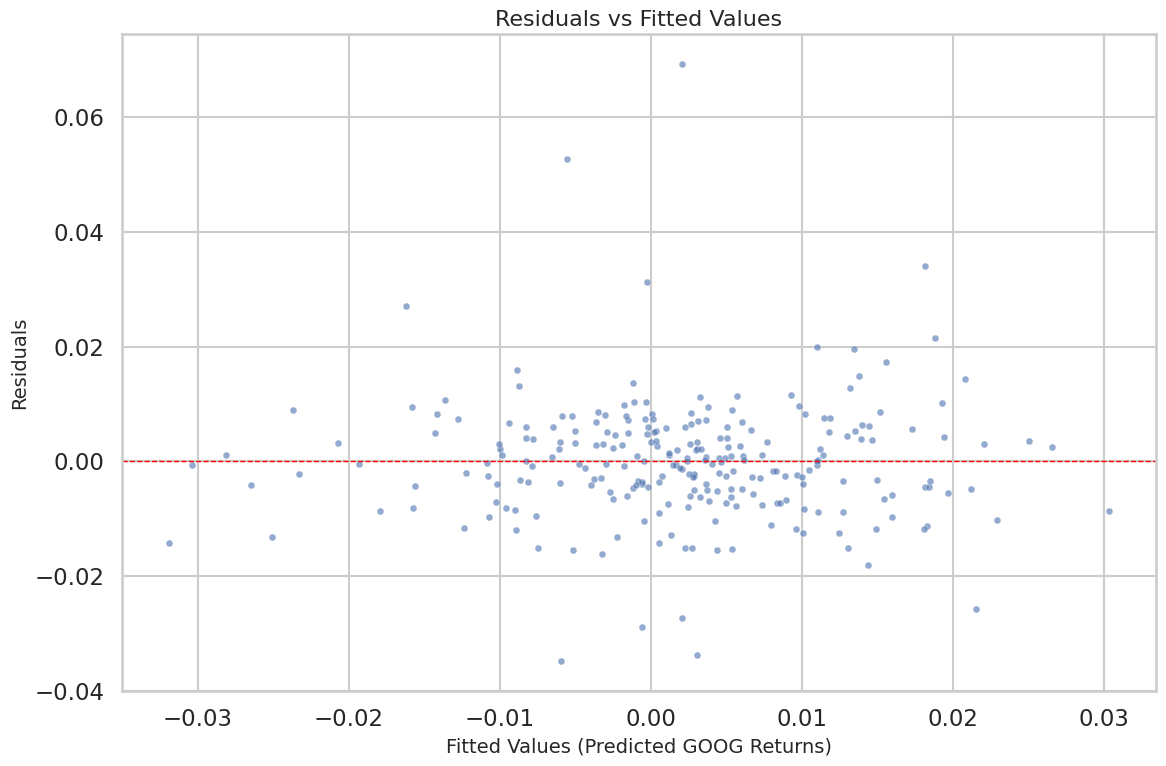

In [36]:
fitted = model.fittedvalues
resid  = model.resid

fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(x=fitted, y=resid, s=25, alpha=0.6, ax=ax)

ax.axhline(0, color="red", linestyle="--", lw=1)

ax.set_title("Residuals vs Fitted Values", fontsize=16)
ax.set_xlabel("Fitted Values (Predicted GOOG Returns)", fontsize=14)
ax.set_ylabel("Residuals", fontsize=14)

plt.tight_layout()
plt.show()

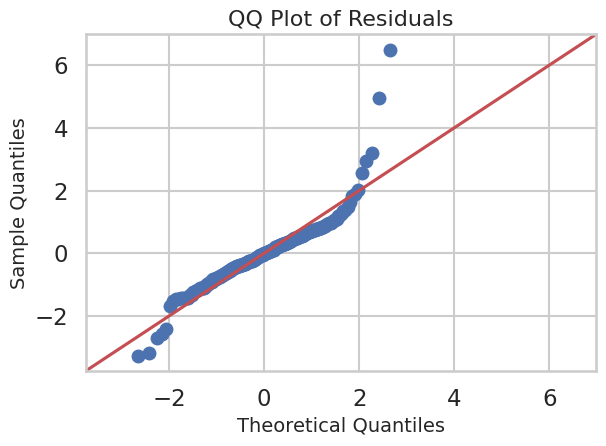

In [38]:
fig = sm.qqplot(resid, line="45", fit=True)

plt.title("QQ Plot of Residuals", fontsize=16)
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)

plt.tight_layout()
plt.show()

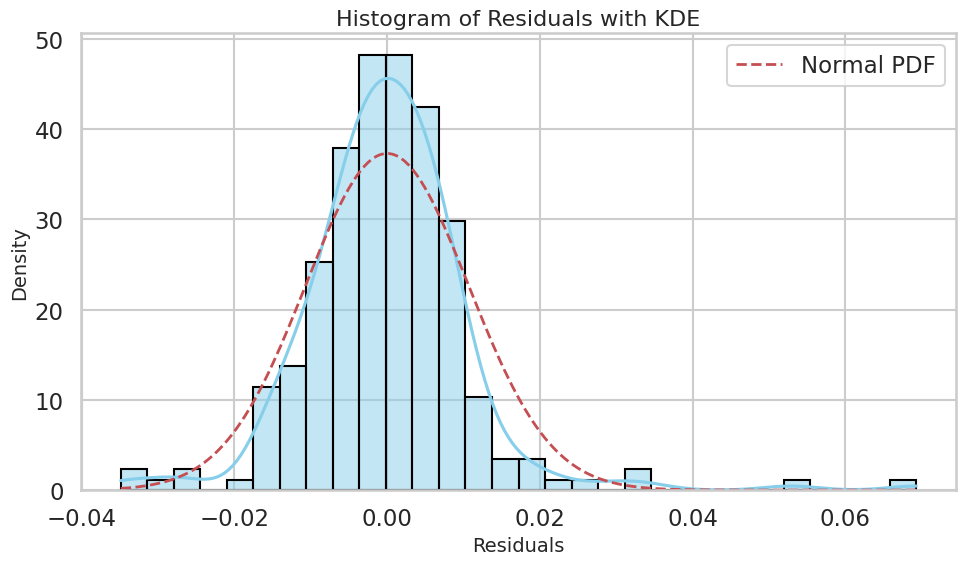

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(10, 6))
sns.histplot(resid, bins=30, kde=True, stat="density", color="skyblue", edgecolor="black")

mu, sigma = resid.mean(), resid.std()
x = np.linspace(resid.min(), resid.max(), 200)
plt.plot(x, stats.norm.pdf(x, mu, sigma), "r--", lw=2, label="Normal PDF")

plt.title("Histogram of Residuals with KDE", fontsize=16)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()